# Cvxpylayers + Neuromancer + Lightning

This notebook is equivalent to parametric_programing/Part_5_cvxpy_layers.ipynb. In this version we showcase the use of **PyTorch-Lightning** to simplify the user workflow. 

This example demonstrates integration of Cvxpylayers into Neuromancer.
We will demonstrate this capability on learning to optimize
for [parametric nonlinear programming problem (pNLP)](https://en.wikipedia.org/wiki/Parametric_programming) defined as:

$$
\begin{align}
&\text{minimize } &&  f(x, \theta) \\
&\text{subject to} && g(x, \theta) \le 0
\end{align}
$$

with  parameters $\theta$ and decision variables $x$.


### Cvxpy Layes References
[1] [Agrawal, A. and Amos, B. and Barratt, S. and Boyd, S. and Diamond, S. and Kolter, Z., Differentiable Convex Optimization Layers, NeurIPS 2019](https://arxiv.org/abs/1910.12430)  
[2] https://github.com/cvxgrp/cvxpylayers/tree/master  
[3] https://locuslab.github.io/2019-10-28-cvxpylayers/  

### Learning to Optimize References
[1] [F. Fioretto, et al., Predicting AC Optimal Power Flows: Combining Deep Learning and Lagrangian Dual Methods, 2019](https://arxiv.org/abs/1909.10461)  
[2] [S. Gould, et al., Deep Declarative Networks: A New Hope, 2020](https://arxiv.org/abs/1909.04866)  
[3] [P. Donti, et al., DC3: A learning method for optimization with hard constraints, 2021](https://arxiv.org/abs/2104.12225)  
[4] [J. Kotary, et al., End-to-End Constrained Optimization Learning: A Survey, 2021](https://arxiv.org/abs/2103.16378)  
[5] [M. Li, et al., Learning to Solve Optimization Problems with Hard Linear Constraints, 2022](https://arxiv.org/abs/2208.10611)  
[6] [R. Sambharya, et al., End-to-End Learning to Warm-Start for Real-Time Quadratic Optimization, 2022](https://arxiv.org/abs/2212.08260)  
[7] [Parametric programming in Neuromancer](https://github.com/pnnl/neuromancer/tree/master/examples/parametric_programming)

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [1]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"
!pip install lightning 

  Cloning https://github.com/pnnl/neuromancer.git (to revision master) to /tmp/pip-install-53vktbvg/neuromancer_65ef9f1060f0401cb2ec971b8342f147
  Running command git clone --filter=blob:none --quiet https://github.com/pnnl/neuromancer.git /tmp/pip-install-53vktbvg/neuromancer_65ef9f1060f0401cb2ec971b8342f147
  Resolved https://github.com/pnnl/neuromancer.git to commit e0f02e592ce32584a03fba52d422aad4bbb4276d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for neuromancer: filename=neuromancer-1.4.2-py3-none-any.whl size=153920 sha256=6b6ea703a02095068498e2871644edbf895e203fa32d9e06f74c131b00c2f9f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-nqxsquma/wheels/88/db/69/58e642f880e17cca6125cfc7a8bcc17b296381c19d2b6598d1
Successfully built neuromancer
  Attempting uninstall: neuromancer
    Found existing installation: neuromancer 1.4.2
    

## Imports

(The user might need to install PyTorch Lightning). If so, please run 

```
pip install lightning
```

### Import

In [6]:
import torch
import torch.nn as nn
import numpy as np
import cvxpy
import lightning.pytorch as pl
from cvxpylayers.torch import CvxpyLayer

# plotting
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

# neuromancer
from neuromancer.trainer import Trainer, LitTrainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node



# Problem Formulation

Specifically we will focus on solving the [Rosenbrock problem](https://en.wikipedia.org/wiki/Rosenbrock_function):

$$
\begin{align}
&\text{minimize } &&  (1-x_1)^2 + p(x_2-x_1^2)^2\\
&\text{subject to} && Ax \le b
\end{align}
$$

with parameters $p, b$ and decision variables $x= [x_1, x_2]$.

In this tutorial, we will use neuromancer to train the neural network to minimize the nonlinear objective function,
and cvxpy layers to project the solution onto feasible region.

In [7]:
nx = 2              #  number of decision variables
n_con = 4           #  number of constraints
n_p = 1             #  number of objective parameters

# generate fixed parameters of the inequality constraints: Ax <= b
torch.manual_seed(7)
A = torch.FloatTensor(n_con, nx).uniform_(-4, 4)
x0 = torch.full([nx], 0.5)       # controls center of the polytope
s0 = torch.full([n_con], 0.2)    # controls offset from the center of the polytope
b0 = A.mv(x0) + s0

## Dataset

We constructy the dataset by sampling the parametric space.

In [8]:
data_seed = 408  # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed);

Randomly sample parameters from a uniform distribution: $0.5\le p\le2.0$;  $0.2\le a\le1.2$

In [9]:
nsim = 1000  # number of datapoints: increase sample density for more robust results
# create dictionaries with sampled datapoints with uniform distribution
p_low, p_high = 0.2, 5.0,
b_low, b_high = 0.0, 1.0,

def data_setup_function(nsim, p_low, p_high, b_low, b_high): 
    # we sample objective and constraints parameters
    samples_train = {"p": torch.FloatTensor(nsim, n_p).uniform_(p_low, p_high),
                    "b_param": torch.FloatTensor(nsim, n_con).uniform_(b_low, b_high)}
    samples_dev = {"p": torch.FloatTensor(nsim, n_p).uniform_(p_low, p_high),
                "b_param": torch.FloatTensor(nsim, n_con).uniform_(b_low, b_high)}
    samples_test = {"p": torch.FloatTensor(nsim, n_p).uniform_(p_low, p_high),
                    "b_param": torch.FloatTensor(nsim, n_con).uniform_(b_low, b_high)}
    # create named dictionary datasets
    train_data = DictDataset(samples_train, name='train')
    dev_data = DictDataset(samples_dev, name='dev')
    test_data = DictDataset(samples_test, name='test')
    batch_size = 32

    return train_data, dev_data, test_data, batch_size

## Primal Solution Map Architecture

A neural network mapping problem parameters onto primal decision variables:  
$$x = \pi(\theta)$$

In [10]:
# define neural architecture for the trainable solution map
# mapping problem parameters to decitionv ariables
func = blocks.MLP(insize=n_con+n_p, outsize=nx,
                bias=True,
                linear_map=torch.nn.Linear,
                nonlin=nn.ReLU,
                hsizes=[80] * 4)
# wrap neural net into symbolic representation of the solution map via the Node class:
# sol_map(p, bparam) -> xy
sol_map = Node(func, ['p', 'b_param'], ['xy'], name='map')

## Objective in NeuroMANCER


We want to minimize the objective:
$$
\begin{align}
&\text{minimize } &&  (1-x_1)^2 + p(x_2-x_1^2)^2
\end{align}
$$

with $x = [x_1, x_2]$ being decision variables and $p$ being problem parameter.

In [11]:
# define decision variables
xy = variable("xy")
x = variable("xy")[:, [0]]
y = variable("xy")[:, [1]]
# problem parameters sampled in the dataset
p = variable('p')
b_param = variable('b_param')

# objective function
f = (1-x)**2 + p*(y-x**2)**2
nm_obj = f.minimize(weight=10.0, name='obj')

## Cvxpy projection layer

We will use cvxpy layer to implement the projection onto the polytopic constraints:

$$
\begin{align}
& \hat{x}  = \text{argmin}_x && ||x -  \hat{x}  ||_2^2 \\
&\text{subject to} && A \hat{x} \le b
\end{align}
$$

with $x$ being solution obtained from the neural network $x = \pi(\theta)$, and $\hat{x}$ being projected solution onto the feasible set satisfying $A \hat{x} \le b$. Here the problem constraints are parametrized by $b$ and solution from neural network $x$. Hence we can compactly represent this projection operator as:  

$$\hat{x} = \text{proj}_{A x \le b}(x, b) $$

Cvxpy layers allow us to use this projection operator as a differentiable layer in our end-to-end solver pipeline.


<img src="./figs/cvxpylayers_overview.png" width="600">  

In [12]:
# constants, parameters, and variables
A_cvxpy = A.detach().numpy()
b0_cvxpy = b0.detach().numpy()
b_cvxpy = cvxpy.Parameter(n_con)
xy_net = cvxpy.Parameter(nx)      # primal decision from neural net
xy_cvxpy = cvxpy.Variable(nx)     # cvxpy decision variable

# projection problem formulation
cvxpy_obj = cvxpy.Minimize(1.0 * cvxpy.sum_squares(xy_net - xy_cvxpy))
cvxpy_cons = [xy_cvxpy@A_cvxpy.T <= b0_cvxpy + b_cvxpy]
cvxpy_prob = cvxpy.Problem(cvxpy_obj, cvxpy_cons)

# cvxpy layer
cvxpy_layer = CvxpyLayer(cvxpy_prob,
                   parameters=[b_cvxpy, xy_net],
                   variables=[xy_cvxpy])

# symbolic wrapper: sol_map(bparam, xy) -> xy
project = Node(cvxpy_layer, ['b_param', 'xy'], ['xy_cvx'], name='proj')

Note that in the above code, we did not need to wrap A_cvxpy, b0_cvxpy etc within a LightningModule class

## Self-supervised loss

We can use the correction form the cvxpylayer as a supervisory signal for the neural network alongside with the objective minimization loss function term. This extra term can be used as a guide for the neural network to satisfy constraints of the problem by following the projected solution. The larger the weigthing factor of this loss function term the closer the neural network will be to feasible region on its own without the subsequent projection.

In [13]:
# corrected variable by the cvxpy layer
xy_cvx = variable("xy_cvx")
# cvxpy-supervised loss for the neural net
residual = torch.abs(xy - xy_cvx)
cvxp_loss = 1.*(residual == 0)

## Construct differentiable parametric optimization problem 

Here we put all the pieces together and construct differentiable parametric constrained optimization problem with neural network and cvxpy projection layer as solvers.

In [14]:
# constrained optimization problem construction
objectives = [nm_obj, cvxp_loss]
constraints = []
nodes = [sol_map, project]

# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(nodes, loss)
# plot computational graph
# problem.show()

## Parametric Problem Solution in NeuroMANCER

Here we will use stochastic gradient descent to optimize the neural network $x = \pi({\theta})$ to solve a distribution of sampled problem instances.

In [15]:
lit_trainer = LitTrainer(epochs=5, patience=10, accelerator='gpu', devices=[1])
lit_trainer.fit(problem, data_setup_function, nsim=nsim, p_low=p_low, p_high=p_high, b_low=b_low, b_high=b_high)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory ./ exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type    | Params
------------------------------------
0 | problem | Problem | 20.1 K
------------------------------------
20.1 K    Trainable params
0         Non-trainable params
20.1 K    Total params
0.080     Total estimated model params size

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:05<00:05,  0.18it/s]

/home/birm560/neuromancer/src/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([32, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)
/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s, v_num=24, train_loss_step=0.539]

/home/birm560/neuromancer/src/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([8, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)
/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 32/32 [00:21<00:00,  1.48it/s, v_num=24, train_loss_step=0.539, dev_loss=0.614, train_loss_epoch=2.680]epoch: 0  : 2.6311771869659424


Epoch 0, global step 32: 'dev_loss' reached 0.61403 (best 0.61403), saving model to './epoch=0-step=32.ckpt' as top 1


Epoch 1: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s, v_num=24, train_loss_step=0.423, dev_loss=0.590, train_loss_epoch=0.789]epoch: 1  : 0.7808655500411987


Epoch 1, global step 64: 'dev_loss' reached 0.59040 (best 0.59040), saving model to './epoch=1-step=64.ckpt' as top 1


Epoch 2: 100%|██████████| 32/32 [00:21<00:00,  1.47it/s, v_num=24, train_loss_step=0.555, dev_loss=0.646, train_loss_epoch=0.618]

Epoch 2, global step 96: 'dev_loss' was not in top 1


epoch: 2  : 0.6163569688796997
Epoch 3: 100%|██████████| 32/32 [00:22<00:00,  1.40it/s, v_num=24, train_loss_step=0.220, dev_loss=0.256, train_loss_epoch=0.552]epoch: 3  : 0.5445245504379272


Epoch 3, global step 128: 'dev_loss' reached 0.25570 (best 0.25570), saving model to './epoch=3-step=128-v1.ckpt' as top 1


Epoch 4: 100%|██████████| 32/32 [00:23<00:00,  1.39it/s, v_num=24, train_loss_step=0.221, dev_loss=0.303, train_loss_epoch=0.483]

Epoch 4, global step 160: 'dev_loss' was not in top 1


epoch: 4  : 0.47689807415008545


`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 32/32 [00:23<00:00,  1.36it/s, v_num=24, train_loss_step=0.221, dev_loss=0.303, train_loss_epoch=0.483]


## Plot the solution

In [16]:
def plot_pNLP(p, b_param, savedir=None):
    # sample primal solution domain
    x1 = np.arange(-0.5, 1.5, 0.02)
    y1 = np.arange(-0.5, 1.5, 0.02)
    xx, yy = np.meshgrid(x1, y1)
    xy_samples = np.stack([xx.flatten(), yy.flatten()])

    # eval constraints Ax - b <= 0
    A_np = A.detach().numpy()
    b = b0 + b_param
    b_np = b.detach().numpy()
    C_samples = np.subtract(np.matmul(A_np, xy_samples).T, b_np).T
    C_samples = C_samples.reshape(n_con, x1.shape[0], y1.shape[0])

    # eval objective
    p_np = p.detach().numpy()
    J = (1 - xx) ** 2 + p_np * (yy - xx ** 2) ** 2

    # plot objective and constraints
    fig, ax = plt.subplots(1, 1)
    cp = ax.contourf(xx, yy, J,
                     levels=[0, 0.05, 0.2, 0.5, 1.0, 2.0, 4.0, 6.0, 8.0, 16],
                     alpha=0.6)
    fig.colorbar(cp)
    ax.set_title('Rosenbrock problem')
    for k in range(n_con):
        cg1 = ax.contour(xx, yy, -C_samples[k], [0],
                         colors='mediumblue', alpha=0.7)
        plt.setp(cg1.collections,
                 path_effects=[patheffects.withTickedStroke()], alpha=0.7)

    # Solution to pNLP via Neuromancer
    datapoint = {'p': p, 'b_param': b_param,
                 'name': 'test'}
    # evaluate neuromancer model
    model_out = problem.step(datapoint)
    # neural net solution
    x_nm_net = model_out["xy"][0].detach().numpy()
    y_nm_net = model_out["xy"][1].detach().numpy()
    # cvxpy projected solution
    x_nm_cvx = model_out["xy_cvx"][0].detach().numpy()
    y_nm_cvx = model_out["xy_cvx"][1].detach().numpy()

    # plot optimal solutions CasADi vs Neuromancer
    ax.plot(x_nm_net, y_nm_net, 'r*', fillstyle='none',
            markersize=16, label='net')
    ax.plot(x_nm_cvx, y_nm_cvx, 'g*', fillstyle='none',
            markersize=14, label='cvxpy')
    # plot projection step
    ax.plot([x_nm_net, x_nm_cvx],
            [y_nm_net, y_nm_cvx], '--', c='orange')
    plt.legend(bbox_to_anchor=(1.0, 0.15))

    if savedir is not None:
        if not os.path.exists(savedir):
            os.mkdir(savedir)
        figure_path = os.path.join(savedir, f'pNLP_p={p}_bsum={b_np}.png')
        plt.savefig(figure_path)
        return figure_path
    else:
        plt.show(block=True)


/tmp/ipykernel_229275/2558518230.py:29: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg1.collections,


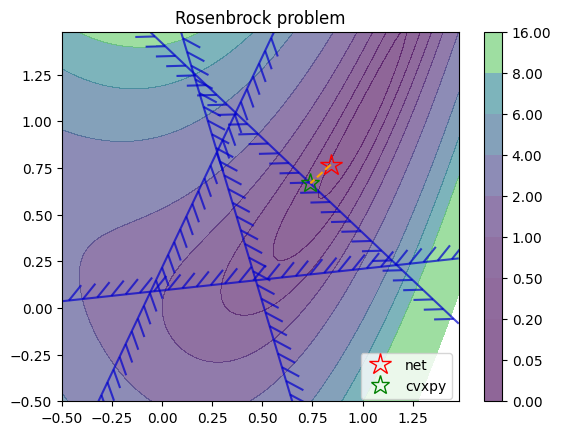

In [17]:
# sample random scenario
p = torch.FloatTensor(n_p).uniform_(p_low, p_high)
b_param = torch.rand(n_con)
# plot single random scenario
plot_pNLP(p, b_param)